#### Libraries :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### 1. Data Gathering

In [2]:
df = pd.read_csv('spotify-2023.csv', encoding = 'ISO-8859-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [3]:
#check column names
df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

In [4]:
#check shape of data
df.shape

(953, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

#### 1.1 Handling Missing Values

In [6]:
#check missing values
df.isnull().sum()

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

In [7]:
#percentage missing value
missing_shazam_charts =(df['in_shazam_charts'].isnull().sum()/len(df))*100
missing_key =(df['key'].isnull().sum()/len(df))*100

print("% missing values in shazam charts column :", missing_shazam_charts)
print("% missing values in key column :", missing_key)

% missing values in shazam charts column : 5.246589716684155
% missing values in key column : 9.968520461699896


* shazam charts : since this represent ranking, missing values likely indicate that song didn't achieve a rank

* Our Strategy: We opted to handle the missing data in two ways:

    1.For interpretability, we created a copy of the column and filled missing values with a "Not Ranked" placeholder. This maintains clarity for anyone inspecting the dataset manually.

    2.For machine learning readiness, another copy of the column was made. Here, missing values are replaced with a numerical value (max_rank + 1). This ensures models receive purely numerical input without losing the information that these songs weren't ranked.
    
    
* This dual approach retains the integrity of the original data while making it usable for various analytical purposes.

In [8]:
#create a copy of human redable data
df['in_shazam_charts_readable'] = df['in_shazam_charts']
df['in_shazam_charts'] = df['in_shazam_charts'].replace({',':''},regex=True).astype(float)
df['in_shazam_charts_readable'].fillna('Not ranked', inplace=True)

In [9]:
#create a copy for ML processing
df['in_shazam_charts_ML'] = df['in_shazam_charts']
max_rank = df['in_shazam_charts_ML'].max()
df['in_shazam_charts_ML'].fillna(max_rank+1, inplace=True)
df.drop('in_shazam_charts',axis=1, inplace=True)

df['in_shazam_charts_ML'] = df['in_shazam_charts_ML'].astype(int)

* Key :

   * Analysis: This attribute signifies the musical key in which the song is composed. Assigning mean, median, or mode might be inappropriate and potentially misleading unless the missing values occur randomly without a discernable pattern.

   * Our Strategy: Given the nature of the 'key' attribute and considering its importance in our analysis, we have decided to remove the rows with missing key values to maintain the integrity and quality of our dataset. This approach ensures that we're working with complete data for each song in our subsequent analyses.

In [10]:
df = df.dropna(subset=['key'])
df.isnull().sum()

track_name                   0
artist(s)_name               0
artist_count                 0
released_year                0
released_month               0
released_day                 0
in_spotify_playlists         0
in_spotify_charts            0
streams                      0
in_apple_playlists           0
in_apple_charts              0
in_deezer_playlists          0
in_deezer_charts             0
bpm                          0
key                          0
mode                         0
danceability_%               0
valence_%                    0
energy_%                     0
acousticness_%               0
instrumentalness_%           0
liveness_%                   0
speechiness_%                0
in_shazam_charts_readable    0
in_shazam_charts_ML          0
dtype: int64

#### 1.2 Dealing with datatypes

In [11]:
#Inspect Current datatypes
df.dtypes

track_name                   object
artist(s)_name               object
artist_count                  int64
released_year                 int64
released_month                int64
released_day                  int64
in_spotify_playlists          int64
in_spotify_charts             int64
streams                      object
in_apple_playlists            int64
in_apple_charts               int64
in_deezer_playlists          object
in_deezer_charts              int64
bpm                           int64
key                          object
mode                         object
danceability_%                int64
valence_%                     int64
energy_%                      int64
acousticness_%                int64
instrumentalness_%            int64
liveness_%                    int64
speechiness_%                 int64
in_shazam_charts_readable    object
in_shazam_charts_ML           int32
dtype: object

In [12]:
# combine released year, released month and released day into one columns
df['released_date'] = pd.to_datetime(df['released_year'].astype(str)+'-'+ 
                                     df['released_month'].astype(str)+'-'+
                                     df['released_day'].astype(str))
df['released_date'].head()

0   2023-07-14
1   2023-03-23
2   2023-06-30
3   2019-08-23
4   2023-05-18
Name: released_date, dtype: datetime64[ns]

In [17]:
#convert 'streams' and 'in_deezer_playlists' to appropriate datatype
df['streams'] = pd.to_numeric(df['streams'], errors ='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'],errors='coerce')

In [19]:
print(df['streams'].dtype)
print(df['in_deezer_playlists'].dtype)

float64
float64


In [26]:
#missing values in 'streams' and 'in_deezer_playlists'
print("Number of missing values in streams :",df['streams'].isnull().sum())
print("Number of missing values in deezer playlists :", df['in_deezer_playlists'].isnull().sum())

Number of missing values in streams : 1
Number of missing values in deezer playlists : 75


In [29]:
df[df['streams'].isna()]

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,in_shazam_charts_readable,in_shazam_charts_ML,released_date
574,Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,0,NaN,16,...,53,75,69,7,0,17,3,0,0,1970-01-01


In [32]:
#remove the row from dataframe
df.dropna(subset=['streams'],inplace=True)

#verify if its dropped
df[df['streams'].isna()]

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,in_shazam_charts_readable,in_shazam_charts_ML,released_date


In [34]:
df[df['in_deezer_playlists'].isna()].head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,in_shazam_charts_readable,in_shazam_charts_ML,released_date
48,Starboy,"The Weeknd, Daft Punk",2,2016,9,21,29536,79,2.565530e+09,281,...,68,49,59,16,0,13,28,140,140,2016-09-21
54,Another Love,Tom Odell,1,2012,10,15,18371,83,1.813674e+09,250,...,45,13,54,70,0,9,4,Not ranked,1452,2012-10-15
55,Blinding Lights,The Weeknd,1,2019,11,29,43899,69,3.703895e+09,672,...,50,38,80,0,0,9,7,Not ranked,1452,2019-11-29
65,Yellow,Chris Molitor,1,1999,1,1,31358,43,1.755214e+09,196,...,43,28,66,0,0,23,3,0,0,1999-01-01
73,Sweater Weather,The Neighbourhood,1,2012,5,14,16413,61,2.282771e+09,166,...,61,41,81,5,2,10,3,Not ranked,1452,2012-05-14


In [35]:
df['in_deezer_playlists'].fillna(0,inplace=True)

In [37]:
#revised datatypes
df.dtypes

track_name                           object
artist(s)_name                       object
artist_count                          int64
released_year                         int64
released_month                        int64
released_day                          int64
in_spotify_playlists                  int64
in_spotify_charts                     int64
streams                             float64
in_apple_playlists                    int64
in_apple_charts                       int64
in_deezer_playlists                 float64
in_deezer_charts                      int64
bpm                                   int64
key                                  object
mode                                 object
danceability_%                        int64
valence_%                             int64
energy_%                              int64
acousticness_%                        int64
instrumentalness_%                    int64
liveness_%                            int64
speechiness_%                   

In [38]:
#encoding of 'mode' and 'key' columns
#one hot encoding the 'mode' column keeping the original column untouched

mode_encoded = pd.get_dummies(df['mode'], prefix='mode')
df = pd.concat([df,mode_encoded], axis=1)

In [39]:
#label encoding 'key' column while keeping the original untouched
label_encoder = LabelEncoder()
df['key_encoded'] = label_encoder.fit_transform(df['key'].astype(str))

In [40]:
df[['mode',*mode_encoded.columns, 'key','key_encoded']]

,mode,mode_Major,mode_Minor,key,key_encoded
0,Major,1,0,B,2
1,Major,1,0,C#,3
2,Major,1,0,F,7
3,Major,1,0,A,0
4,Minor,0,1,A,0
...,...,...,...,...,...
948,Major,1,0,A,0
949,Major,1,0,F#,8
950,Major,1,0,C#,3
951,Major,1,0,C#,3


In [51]:
#define percentage columns

percentage_columns = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%',
       'instrumentalness_%', 'liveness_%', 'speechiness_%']

percentage_data = df[pd.Series(percentage_columns)]
percentage_data.describe()

,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,67.273046,51.219370,64.339557,26.644107,1.611435,18.175029,10.396733
std,14.653159,23.594579,16.056348,25.688111,8.570734,13.569471,10.090890
min,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000
25%,57.000000,32.000000,53.000000,5.000000,0.000000,10.000000,4.000000
50%,70.000000,51.000000,66.000000,17.000000,0.000000,12.000000,6.000000
75%,78.000000,70.000000,76.000000,42.000000,0.000000,24.000000,12.000000
max,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


In [53]:
#create new scaled percentage columns for ML algorithm
for col in percentage_columns:
    df[col+'_ML'] = df[col]/100.0

### 2. Advance Data Analytics

#### 2.1 Summary

In [56]:
df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,mode_Major,mode_Minor,key_encoded,danceability_%_ML,valence_%_ML,energy_%_ML,acousticness_%_ML,instrumentalness_%_ML,liveness_%_ML,speechiness_%_ML
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,8.570000e+02,857.000000,857.000000,857.000000,...,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,1.551925,2018.297550,6.031505,13.739790,5204.997666,11.959160,5.133554e+08,67.383897,51.044341,96.838973,...,0.553092,0.446908,5.158693,0.672730,0.512194,0.643396,0.266441,0.016114,0.181750,0.103967
std,0.864634,10.991135,3.567138,9.287652,7944.032885,19.194211,5.714855e+08,86.562405,50.407409,169.346061,...,0.497464,0.497464,3.227441,0.146532,0.235946,0.160563,0.256881,0.085707,0.135695,0.100909
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.230000,0.040000,0.140000,0.000000,0.000000,0.030000,0.020000
25%,1.000000,2020.000000,3.000000,5.000000,859.000000,0.000000,1.391938e+08,13.000000,7.000000,8.000000,...,0.000000,0.000000,3.000000,0.570000,0.320000,0.530000,0.050000,0.000000,0.100000,0.040000
50%,1.000000,2022.000000,5.000000,13.000000,2226.000000,3.000000,2.849083e+08,34.000000,38.000000,30.000000,...,1.000000,0.000000,5.000000,0.700000,0.510000,0.660000,0.170000,0.000000,0.120000,0.060000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,6.740727e+08,85.000000,85.000000,99.000000,...,1.000000,1.000000,8.000000,0.780000,0.700000,0.760000,0.420000,0.000000,0.240000,0.120000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,965.000000,...,1.000000,1.000000,10.000000,0.960000,0.970000,0.970000,0.970000,0.910000,0.970000,0.640000


#### 2.2 Histogram

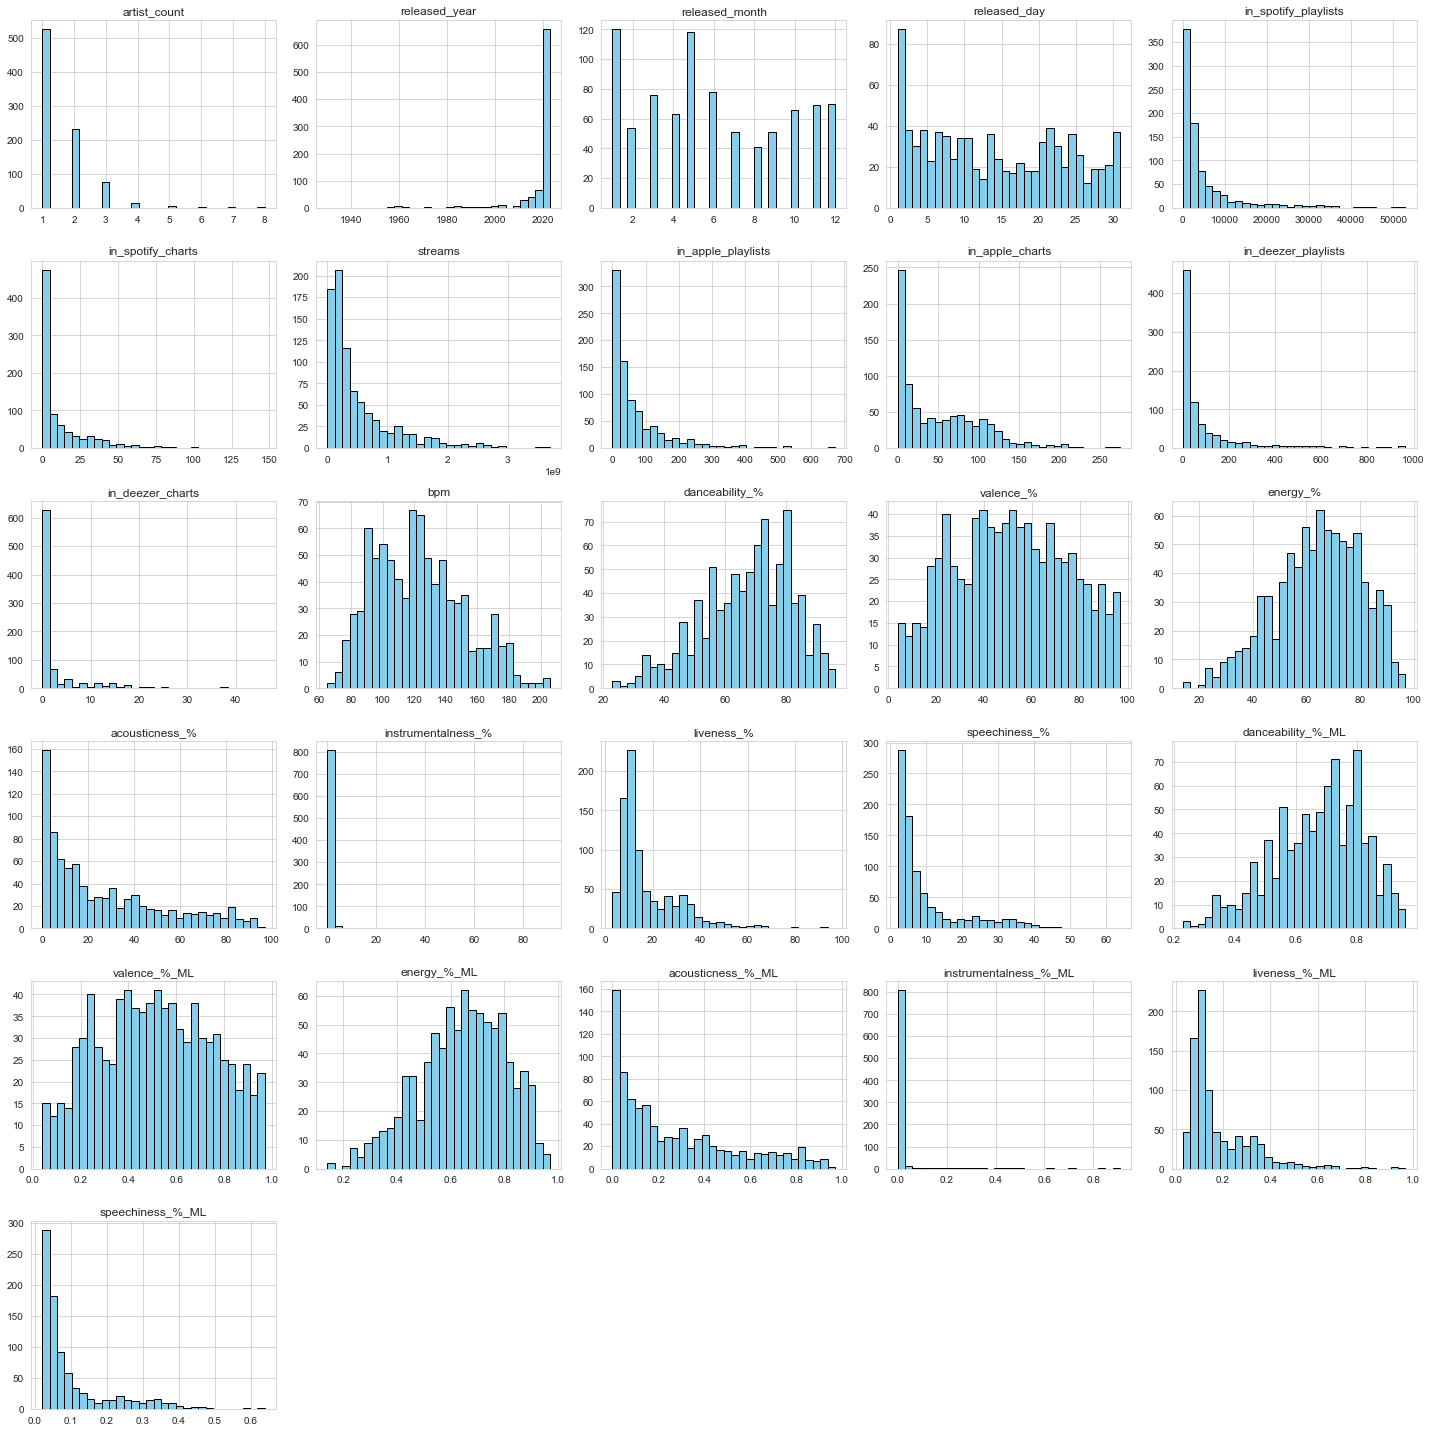

In [58]:
sns.set_style('whitegrid')

#plotting histogram for all numeric columns
df.select_dtypes(include =['float64','int64']).hist(bins=30, figsize=(20,20), color='skyblue',edgecolor='black')
plt.tight_layout()
plt.show()

Based on histogram here are some observations
    
* artist_count : most number of songs are performed by single artist but their are significant number of songs performed by multiple atrist as well
* released_year : bulk of the songs have been released after 1980, with sharp increase in number after 2000. the peak seems to occure in 2020
* released_month : Jan and may appear to be popular month for song release
* release_day : slight peak at the begining of the month but overall song releases distributed throughout the month
* in_playlists and in_charts columns: Most songs are either not present or only appear in a few playlists or charts. However, there's a small subset of songs that seem to dominate in terms of being added to many playlists or making it to the charts.
* bpm (beats per minute): Songs range widely in bpm, but there's a prominent peak around 80-100 bpm, indicating that a moderate tempo is quite popular.
* Danceability, Valence, Energy, and other % metrics: These attributes display varying levels of skewness, but most of them, like danceability and energy, show a wide distribution indicating diverse musical properties.

#### 2.3 Correlation Matrix

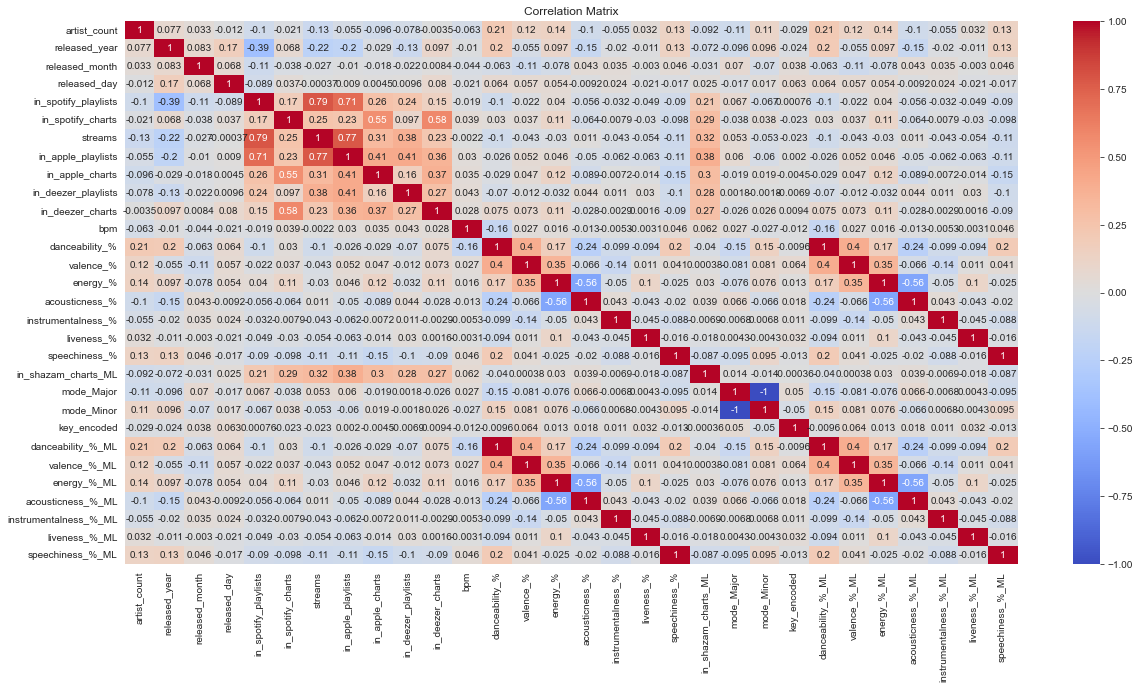

In [62]:
numeric_data = df.select_dtypes(include =[np.number])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
